In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import sklearn

from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
matplotlib.rcParams['font.sans-serif'] = ['SimHei']

### 数据读取

In [2]:
explain_path='./数据说明.txt'
train_path='./train_set.csv'
test_path='./test_set.csv'
explain=pd.read_table(explain_path,sep='\t',index_col='NO')
train=pd.read_csv(train_path)
test=pd.read_csv(test_path)


### 数据展示

In [3]:
#各个字段的含义
explain

,字段名称,数据类型,字段描述
NO,,,
1,ID,Int,客户唯一标识
2,age,Int,客户年龄
3,job,String,客户的职业
4,marital,String,婚姻状况
5,education,String,受教育水平
6,default,String,是否有违约记录
7,balance,Int,每年账户的平均余额
8,housing,String,是否有住房贷款
9,loan,String,是否有个人贷款


In [4]:
#训练集数据有关信息
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25317 entries, 0 to 25316
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         25317 non-null  int64 
 1   age        25317 non-null  int64 
 2   job        25317 non-null  object
 3   marital    25317 non-null  object
 4   education  25317 non-null  object
 5   default    25317 non-null  object
 6   balance    25317 non-null  int64 
 7   housing    25317 non-null  object
 8   loan       25317 non-null  object
 9   contact    25317 non-null  object
 10  day        25317 non-null  int64 
 11  month      25317 non-null  object
 12  duration   25317 non-null  int64 
 13  campaign   25317 non-null  int64 
 14  pdays      25317 non-null  int64 
 15  previous   25317 non-null  int64 
 16  poutcome   25317 non-null  object
 17  y          25317 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 3.5+ MB


In [5]:
#测试集数据有关信息
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10852 entries, 0 to 10851
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         10852 non-null  int64 
 1   age        10852 non-null  int64 
 2   job        10852 non-null  object
 3   marital    10852 non-null  object
 4   education  10852 non-null  object
 5   default    10852 non-null  object
 6   balance    10852 non-null  int64 
 7   housing    10852 non-null  object
 8   loan       10852 non-null  object
 9   contact    10852 non-null  object
 10  day        10852 non-null  int64 
 11  month      10852 non-null  object
 12  duration   10852 non-null  int64 
 13  campaign   10852 non-null  int64 
 14  pdays      10852 non-null  int64 
 15  previous   10852 non-null  int64 
 16  poutcome   10852 non-null  object
dtypes: int64(8), object(9)
memory usage: 1.4+ MB


通过对训练集与测试集有关信息的查看可以得到如下信息
1. 数据一共有17个特征，需要预测的是y（客户是否购买）
2. 训练集有25317个样本，不存在空值
3. 测试集有10852个样本，不存在空值

In [6]:
#训练集数据
train

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1,43,management,married,tertiary,no,291,yes,no,unknown,9,may,150,2,-1,0,unknown,0
1,2,42,technician,divorced,primary,no,5076,yes,no,cellular,7,apr,99,1,251,2,other,0
2,3,47,admin.,married,secondary,no,104,yes,yes,cellular,14,jul,77,2,-1,0,unknown,0
3,4,28,management,single,secondary,no,-994,yes,yes,cellular,18,jul,174,2,-1,0,unknown,0
4,5,42,technician,divorced,secondary,no,2974,yes,no,unknown,21,may,187,5,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25312,25313,55,blue-collar,divorced,primary,no,8180,no,no,cellular,14,may,854,2,360,1,failure,1
25313,25314,52,services,married,secondary,no,961,no,yes,cellular,18,feb,222,1,553,4,failure,1
25314,25315,35,blue-collar,divorced,primary,no,300,yes,no,unknown,13,may,945,2,-1,0,unknown,1
25315,25316,37,entrepreneur,divorced,tertiary,no,66,no,no,cellular,18,nov,1164,2,-1,0,unknown,1


In [7]:
#测试集数据
test

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,25318,51,housemaid,married,unknown,no,174,no,no,telephone,29,jul,308,3,-1,0,unknown
1,25319,32,management,married,tertiary,no,6059,yes,no,cellular,20,nov,110,2,-1,0,unknown
2,25320,60,retired,married,primary,no,0,no,no,telephone,30,jul,130,3,-1,0,unknown
3,25321,32,student,single,tertiary,no,64,no,no,cellular,30,jun,598,4,105,5,failure
4,25322,41,housemaid,married,secondary,no,0,yes,yes,cellular,15,jul,368,4,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10847,36165,29,management,single,tertiary,no,54,yes,yes,unknown,26,may,257,3,-1,0,unknown
10848,36166,35,management,married,secondary,no,674,no,no,cellular,8,aug,87,2,-1,0,unknown
10849,36167,38,services,married,secondary,no,435,yes,no,unknown,23,may,193,2,-1,0,unknown
10850,36168,41,admin.,divorced,secondary,no,783,yes,yes,cellular,14,may,135,3,363,2,failure


通过观察两个数据表的数据，发现有很多为unknown的值，这部分数据是未知的，对于我们分析会造成影响，所以我们后续先看下都有哪些列包含unknown，之后再做进一步处理

### 数据清洗

In [8]:
#为了方便做处理，我把训练集、数据集合在一起处理,而且通过查看训练集和测试集发现根据ID可以把两个数据集很容易的分开
con=pd.concat([train,test]).set_index('ID')
con

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
ID,,,,,,,,,,,,,,,,,
1,43,management,married,tertiary,no,291,yes,no,unknown,9,may,150,2,-1,0,unknown,0.0
2,42,technician,divorced,primary,no,5076,yes,no,cellular,7,apr,99,1,251,2,other,0.0
3,47,admin.,married,secondary,no,104,yes,yes,cellular,14,jul,77,2,-1,0,unknown,0.0
4,28,management,single,secondary,no,-994,yes,yes,cellular,18,jul,174,2,-1,0,unknown,0.0
5,42,technician,divorced,secondary,no,2974,yes,no,unknown,21,may,187,5,-1,0,unknown,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36165,29,management,single,tertiary,no,54,yes,yes,unknown,26,may,257,3,-1,0,unknown,NaN
36166,35,management,married,secondary,no,674,no,no,cellular,8,aug,87,2,-1,0,unknown,NaN
36167,38,services,married,secondary,no,435,yes,no,unknown,23,may,193,2,-1,0,unknown,NaN


In [9]:
#查看每一列有多少unknown
con.replace('unknown',np.nan,inplace=True)
num = con.isna().sum()
num


age              0
job            223
marital          0
education     1513
default          0
balance          0
housing          0
loan             0
contact      10393
day              0
month            0
duration         0
campaign         0
pdays            0
previous         0
poutcome     29554
y            10852
dtype: int64

从图中我们可以发现job（客户的职业）,education（受教育水平）,concat（与客户联系的沟通方式）,poutcome（上一次活动的结果）都包含unknown值
1. 对于poutcome缺失数量实在太多，后续我准备直接删除这一列
2. job缺失较少且数据集数据量比较大，所以我选择删除包含缺失值的一行
3. concat和education我选择用众数填充


In [10]:
con['contact'].mode()

0    cellular
Name: contact, dtype: object

In [11]:
con['education'].mode()

0    secondary
Name: education, dtype: object

In [12]:
con.drop('poutcome',axis=1,inplace=True)
con.dropna(subset=['job'],inplace=True)
con.fillna({'contact':'cellular'},inplace=True)
con.fillna({'education':'secondary'},inplace=True)

In [13]:
con.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35946 entries, 1 to 36169
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        35946 non-null  int64  
 1   job        35946 non-null  object 
 2   marital    35946 non-null  object 
 3   education  35946 non-null  object 
 4   default    35946 non-null  object 
 5   balance    35946 non-null  int64  
 6   housing    35946 non-null  object 
 7   loan       35946 non-null  object 
 8   contact    35946 non-null  object 
 9   day        35946 non-null  int64  
 10  month      35946 non-null  object 
 11  duration   35946 non-null  int64  
 12  campaign   35946 non-null  int64  
 13  pdays      35946 non-null  int64  
 14  previous   35946 non-null  int64  
 15  y          25154 non-null  float64
dtypes: float64(1), int64(7), object(8)
memory usage: 4.7+ MB


数据处理之后只有测试集的y有缺失

### 数据可视化

In [14]:
#训练集处理后的数据剩下25154条
train=con[con.index<=25317]
train

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,y
ID,,,,,,,,,,,,,,,,
1,43,management,married,tertiary,no,291,yes,no,cellular,9,may,150,2,-1,0,0.0
2,42,technician,divorced,primary,no,5076,yes,no,cellular,7,apr,99,1,251,2,0.0
3,47,admin.,married,secondary,no,104,yes,yes,cellular,14,jul,77,2,-1,0,0.0
4,28,management,single,secondary,no,-994,yes,yes,cellular,18,jul,174,2,-1,0,0.0
5,42,technician,divorced,secondary,no,2974,yes,no,cellular,21,may,187,5,-1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25313,55,blue-collar,divorced,primary,no,8180,no,no,cellular,14,may,854,2,360,1,1.0
25314,52,services,married,secondary,no,961,no,yes,cellular,18,feb,222,1,553,4,1.0
25315,35,blue-collar,divorced,primary,no,300,yes,no,cellular,13,may,945,2,-1,0,1.0


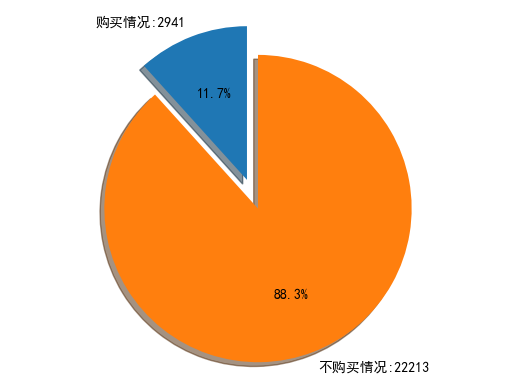

In [15]:
#我们先看下样本是不是倾斜样本，通过饼图来看下购买和不购买理财产品的比例
c_purchase=train[train.loc[:,'y']==1].copy()
c_n_purchase=train[train.loc[:,'y']==0].copy()
pie_data = {'购买情况': c_purchase.shape[0],
            '不购买情况': train.shape[0]-c_purchase.shape[0]}
explode = (0.2, 0)  #  突出购买率

fig1, ax = plt.subplots()
sizes=pie_data.values()
labels =['{}:{}'.format(key,value) for key,value in pie_data.items()]
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax.axis('equal')  # 确保圆形

plt.show()

可以看出，定期理财产品的购买率不高，同时训练样本极其不均衡。后边可以使用过采样解决样本不均衡问题。

最小的年龄：18
最大的年龄：95


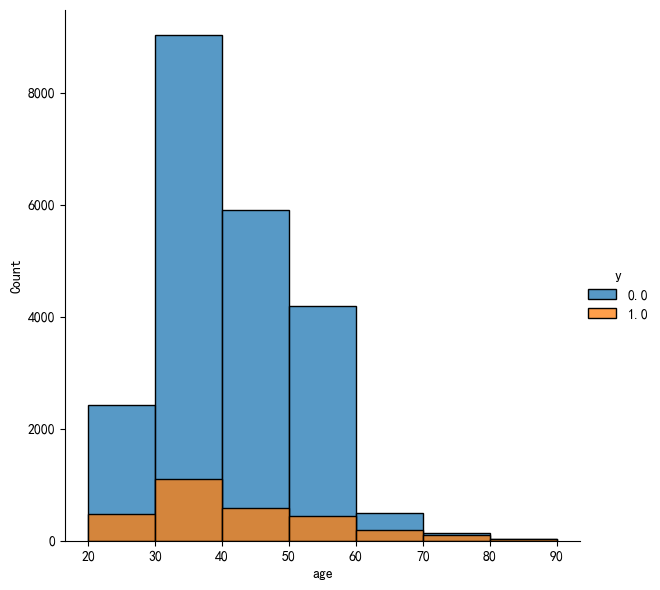

In [16]:
fg = sns.FacetGrid(data=train,height=6,hue='y')
fg = (fg.map(sns.histplot,'age',bins=[20,30,40,50,60,70,80,90])
      .add_legend())
print("最小的年龄：{}".format(train['age'].min()))
print("最大的年龄：{}".format(train['age'].max()))

通过年龄分布直方图发现：

1. 数据样本集中在年龄低的分段
2. 年龄超过60岁和年龄低30岁的人更喜欢定期理财

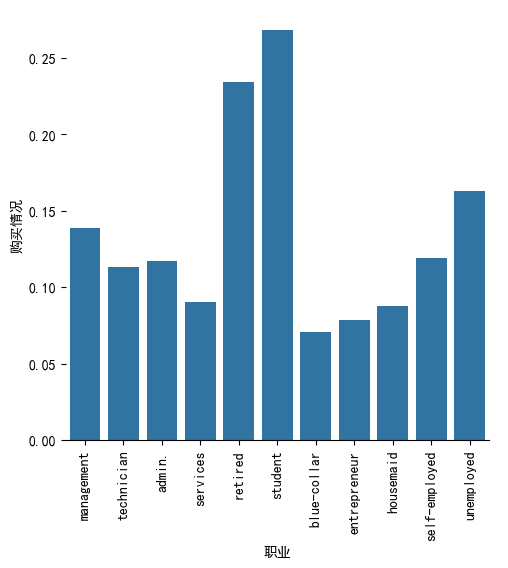

In [17]:
#职业
fg=sns.catplot(data=train,x='job',kind='bar',y='y',errorbar=None)
fg=(fg.set_xticklabels(rotation=90)
    .set_axis_labels('职业','购买情况')
    .despine(left=True))

通过职业分类查看观察到：

1. 退休人员和学生最青睐定期理财，其次是失业人员
2. 蓝领定期理财的比率最低

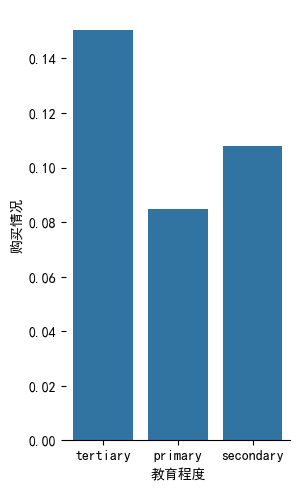

In [18]:
#教育程度
fg=sns.catplot(data=train,x='education',kind='bar',y='y',errorbar=None,aspect=.6)
fg=(fg.set_axis_labels('教育程度','购买情况')
    .despine(left=True))

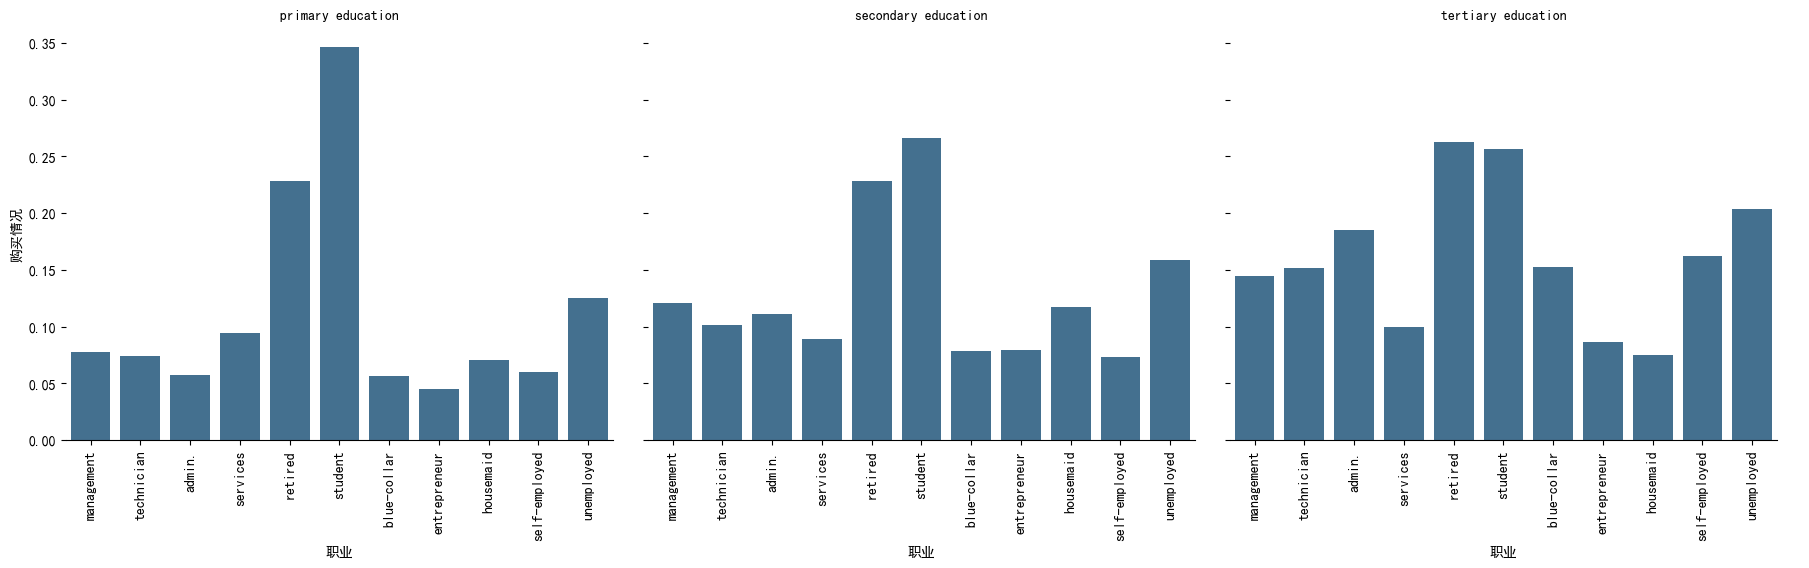

In [19]:
#不同教育程度，不同职业的购买情况
g = sns.catplot(x='job', y='y', col='education',
                data=train, saturation=.5,
                kind='bar', col_order=['primary','secondary','tertiary'],
                aspect=1.2,errorbar=None)
g = (g.set_axis_labels('职业', '购买情况')
     .set_xticklabels(rotation=90)
     .set_titles('{col_name} {col_var}')
     .despine(left=True))


从上图我们观察到：

1. 无论接受教育的程度如何，进行定期理财的人主要是退休人员和学生，其次是失业人员。
2. 随着教育程度的提高，管理人员、技术人员、行政人员、蓝领、企业家、自由职业者、事业人员越来越倾向接受定期理财。

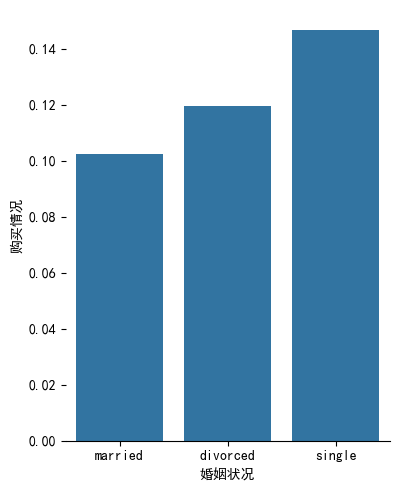

In [20]:
#婚姻状况
fg=sns.catplot(data=train,x='marital',kind='bar',y='y',errorbar=None,aspect=.8)
fg=(fg.set_axis_labels('婚姻状况','购买情况')
    .despine(left=True))

按照婚姻情况分类观察到：

单身相比离异和已婚倾向于定期理财。

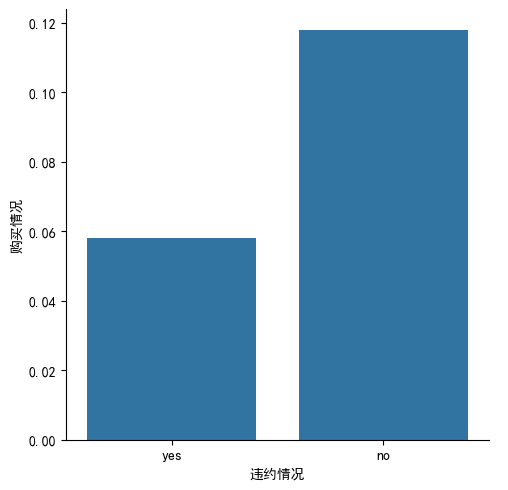

In [21]:
#违约与定期理财
fg=sns.catplot(data=train,x='default',kind='bar',y='y',errorbar=None,order=['yes','no'])
fg.set_axis_labels("违约情况",'购买情况')

没有违约的人倾向于定期理财

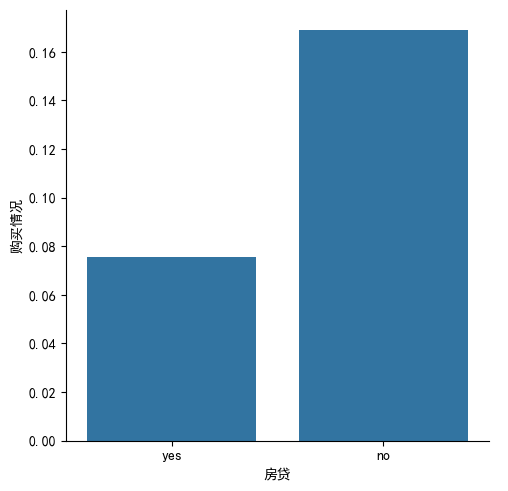

In [22]:
fg=sns.catplot(data=train,x='housing',kind='bar',y='y',errorbar=None,order=['yes','no'])
fg.set_axis_labels("房贷",'购买情况')


没有房贷的人倾向于定期理财

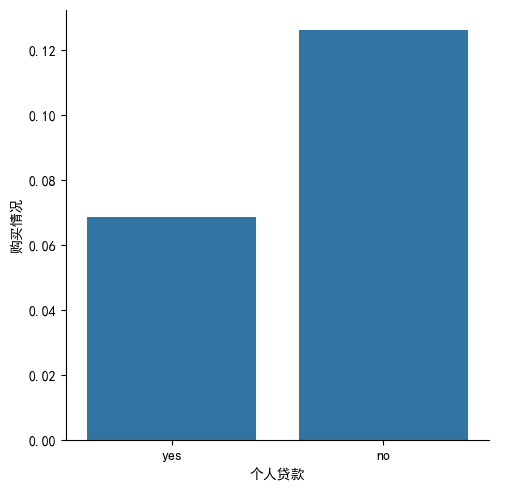

In [23]:
fg=sns.catplot(data=train,x='loan',kind='bar',y='y',errorbar=None,order=['yes','no'])
fg.set_axis_labels("个人贷款",'购买情况')

没有个人贷款的人倾向于定期理财

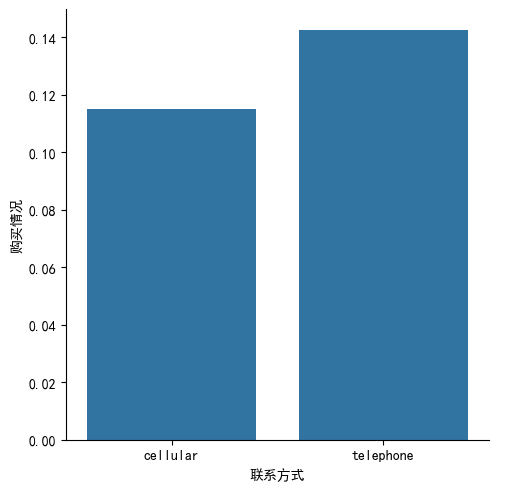

In [24]:
fg=sns.catplot(data=train,x='contact',kind='bar',y='y',errorbar=None)
fg.set_axis_labels("联系方式",'购买情况')

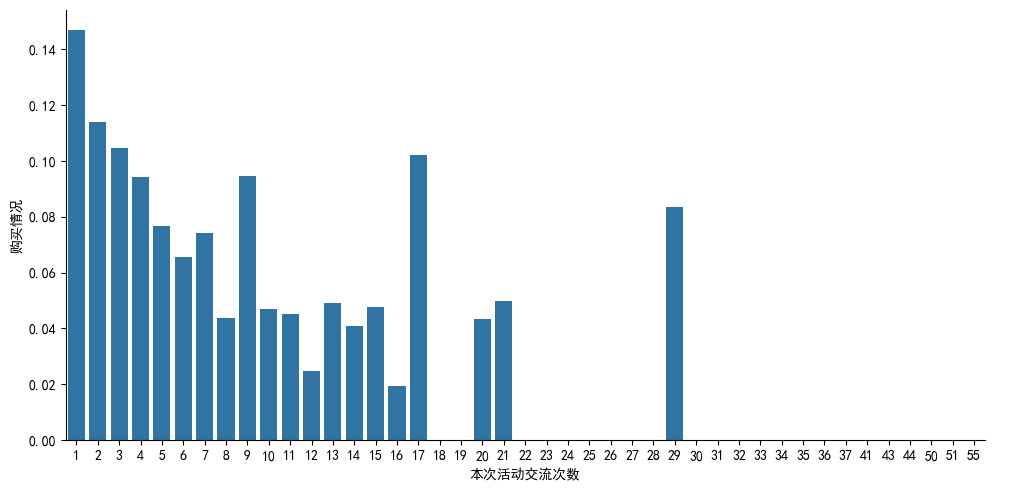

In [25]:
fg=sns.catplot(data=train,x='campaign',kind='bar',y='y',errorbar=None,aspect=2)
fg.set_axis_labels("本次活动交流次数",'购买情况')


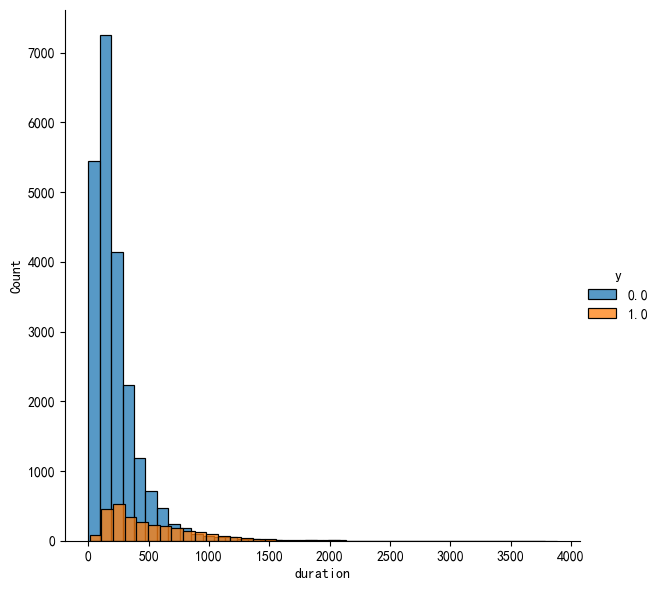

In [26]:
fg = sns.FacetGrid(data=train,height=6,hue='y')
fg = (fg.map(sns.histplot,'duration',bins=40)
      .add_legend())

通过沟通方式等特征分析观察到：

1. 通过移动电话沟通客户定期理财的比率高
2. 沟通次数长并不一定能够提高客户进行定期理财的比率
3. 最后一次沟通的超过一定时长（大约300）后定期理财比率提高


<Axes: >

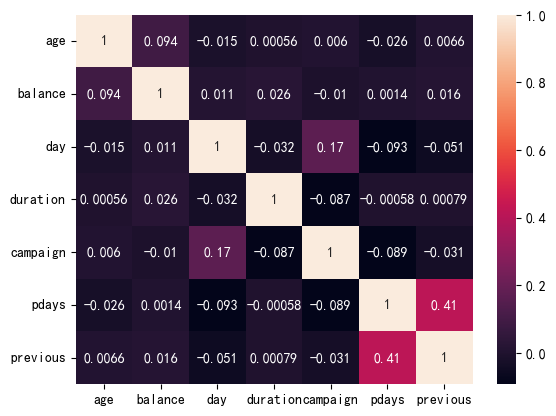

In [27]:
dtype_df = train.dtypes
cols = dtype_df.iloc[(dtype_df=='int64').values].index
sns.heatmap(data=train[cols].corr(),annot=True)

pearson系数，duration（最后一次联系的交流时长）与预测值成弱相关性，pdays（距离上次活动最后一次联系该客户，过去了多久）和previous（在本次活动之前，与该客户交流过的次数）成相关性。

### 数据集预处理


In [29]:
#字符串标签化
def discrete(col, name):
    a=pd.DataFrame(col.value_counts()).reset_index()
    b=a.to_dict('list')
    print("b", b)
    c=dict(zip(b[name], b['count']))
    print("c", c)
    return c
#月份转换成相应的数值   
def month_to_int(col):
    mon_dict={'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}
    col=col.map(mon_dict)
    return col

In [30]:
con2 = con
con2['job']=con['job'].map(discrete(con['job'], 'job'))
con2['marital']=con['marital'].map(discrete(con['marital'], 'marital'))
con2['education']=con['education'].map(discrete(con['education'], 'education'))
con2['default']=con['default'].map(discrete(con['default'], 'default'))
con2['housing']=con['housing'].map(discrete(con['housing'], 'housing'))
con2['loan']=con['loan'].map(discrete(con['loan'], 'loan'))
con2['contact']=con['contact'].map(discrete(con['contact'], 'contact'))
con2['month']=month_to_int(con['month'])

b {'job': ['blue-collar', 'management', 'technician', 'admin.', 'services', 'retired', 'self-employed', 'entrepreneur', 'unemployed', 'housemaid', 'student'], 'count': [7763, 7595, 6083, 4124, 3308, 1828, 1275, 1185, 1024, 979, 782]}
c {'blue-collar': 7763, 'management': 7595, 'technician': 6083, 'admin.': 4124, 'services': 3308, 'retired': 1828, 'self-employed': 1275, 'entrepreneur': 1185, 'unemployed': 1024, 'housemaid': 979, 'student': 782}
b {'marital': ['married', 'single', 'divorced'], 'count': [21701, 10116, 4129]}
c {'married': 21701, 'single': 10116, 'divorced': 4129}
b {'education': ['secondary', 'tertiary', 'primary'], 'count': [19868, 10625, 5453]}
c {'secondary': 19868, 'tertiary': 10625, 'primary': 5453}
b {'default': ['no', 'yes'], 'count': [35301, 645]}
c {'no': 35301, 'yes': 645}
b {'housing': ['yes', 'no'], 'count': [19940, 16006]}
c {'yes': 19940, 'no': 16006}
b {'loan': ['no', 'yes'], 'count': [30143, 5803]}
c {'no': 30143, 'yes': 5803}
b {'contact': ['cellular', 't

In [31]:
con

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,y
ID,,,,,,,,,,,,,,,,
1,43,7595,21701,10625,35301,291,19940,30143,33642,9,5,150,2,-1,0,0.0
2,42,6083,4129,5453,35301,5076,19940,30143,33642,7,4,99,1,251,2,0.0
3,47,4124,21701,19868,35301,104,19940,5803,33642,14,7,77,2,-1,0,0.0
4,28,7595,10116,19868,35301,-994,19940,5803,33642,18,7,174,2,-1,0,0.0
5,42,6083,4129,19868,35301,2974,19940,30143,33642,21,5,187,5,-1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36165,29,7595,10116,10625,35301,54,19940,5803,33642,26,5,257,3,-1,0,NaN
36166,35,7595,21701,19868,35301,674,16006,30143,33642,8,8,87,2,-1,0,NaN
36167,38,3308,21701,19868,35301,435,19940,30143,33642,23,5,193,2,-1,0,NaN


In [38]:
train=con2[con2.index<=25317]
test=con2[con2.index>25317]

In [48]:
from sklearn import tree
import graphviz
from imblearn.over_sampling import SMOTE
y = train['y']
X = train.drop(['y'],axis=1).select_dtypes(exclude=['object'])
oversampler=SMOTE(random_state=0)
os_X,os_y=oversampler.fit_resample(X,y)

In [59]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(os_X.values, os_y.values, test_size=0.3)
print(train_x)

[[   42  1185 21701 ...     1   140     4]
 [   51  7595 21701 ...     1    -1     0]
 [   34  7763 10116 ...     1   343     2]
 ...
 [   34  6083 10116 ...     1    -1     0]
 [   53  4124 21701 ...     1    -1     0]
 [   52  4023 10116 ...     1    10     0]]


In [60]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25154 entries, 1 to 25317
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        25154 non-null  int64  
 1   job        25154 non-null  int64  
 2   marital    25154 non-null  int64  
 3   education  25154 non-null  int64  
 4   default    25154 non-null  int64  
 5   balance    25154 non-null  int64  
 6   housing    25154 non-null  int64  
 7   loan       25154 non-null  int64  
 8   contact    25154 non-null  int64  
 9   day        25154 non-null  int64  
 10  month      25154 non-null  int64  
 11  duration   25154 non-null  int64  
 12  campaign   25154 non-null  int64  
 13  pdays      25154 non-null  int64  
 14  previous   25154 non-null  int64  
 15  y          25154 non-null  float64
dtypes: float64(1), int64(15)
memory usage: 3.3 MB


In [65]:
model_tree=tree.DecisionTreeClassifier(criterion="gini",random_state=10,splitter="best")
params_test={
    'max_depth':range(10,15,1),
    'min_samples_leaf':range(1,7,1),
    'min_samples_split':range(15,25,1)
}
gsearch = GridSearchCV(estimator=model_tree, param_grid=params_test, scoring='accuracy', cv=5, verbose=1, n_jobs=4)
gsearch.fit(train_x, train_y)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=10), n_jobs=4,
             param_grid={'max_depth': range(10, 15),
                         'min_samples_leaf': range(1, 7),
                         'min_samples_split': range(15, 25)},
             scoring='accuracy', verbose=1)

In [66]:
gsearch.best_params_

{'max_depth': 12, 'min_samples_leaf': 3, 'min_samples_split': 15}

In [70]:
gsearch.best_estimator_

DecisionTreeClassifier(max_depth=12, min_samples_leaf=3, min_samples_split=15,
                       random_state=10)

In [73]:
from sklearn.metrics import accuracy_score

p=gsearch.predict(test_x)
print(accuracy_score(test_y, p))

0.8777010804321729


In [ ]:
test=test.drop('y',axis=1)

In [ ]:
test

In [ ]:
result=tr.predict(test)

In [ ]:
test['pre']=result
test